<a href="https://colab.research.google.com/github/Mr-SuSeL/NeuralNetworkPredictsDowJones/blob/main/Projekt_Sieci_Neuronowe_PrognozaKursuAkcji.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
# Dane pobrane z portalu stooq.pl
#stocks = 'https://raw.githubusercontent.com/Mr-SuSeL/NeuralNetworkPredictsDowJones/main/19880101_20191231.csv'
stocks = 'https://raw.githubusercontent.com/Mr-SuSeL/NeuralNetworkPredictsDowJones/main/dji.csv'
data_raw = pd.read_csv(stocks, index_col='Date')

In [2]:
def generate_features(df):
    """
    Generujemy cechy, dane notowań giełdowego indeksu i stopy zwrotu
    @param df: ramka danych z nagłówkami: "Open", "Close", "High", "Low", "Volume"
    @return: datazwracamy ramkę danych z nowymi ustawieniami
    """
    df_new = pd.DataFrame()
    # 6 original features
    df_new['open'] = df['Open']
    df_new['open_1'] = df['Open'].shift(1)
    df_new['close_1'] = df['Close'].shift(1)
    df_new['high_1'] = df['High'].shift(1)
    df_new['low_1'] = df['Low'].shift(1)
    df_new['volume_1'] = df['Volume'].shift(1)
    # 31 generated features
    # average price
    df_new['avg_price_5'] = df['Close'].rolling(5).mean().shift(1)
    df_new['avg_price_30'] = df['Close'].rolling(21).mean().shift(1)
    df_new['avg_price_365'] = df['Close'].rolling(252).mean().shift(1)
    df_new['ratio_avg_price_5_30'] = df_new['avg_price_5'] / df_new['avg_price_30']
    df_new['ratio_avg_price_5_365'] = df_new['avg_price_5'] / df_new['avg_price_365']
    df_new['ratio_avg_price_30_365'] = df_new['avg_price_30'] / df_new['avg_price_365']
    # average volume
    df_new['avg_volume_5'] = df['Volume'].rolling(5).mean().shift(1)
    df_new['avg_volume_30'] = df['Volume'].rolling(21).mean().shift(1)
    df_new['avg_volume_365'] = df['Volume'].rolling(252).mean().shift(1)
    df_new['ratio_avg_volume_5_30'] = df_new['avg_volume_5'] / df_new['avg_volume_30']
    df_new['ratio_avg_volume_5_365'] = df_new['avg_volume_5'] / df_new['avg_volume_365']
    df_new['ratio_avg_volume_30_365'] = df_new['avg_volume_30'] / df_new['avg_volume_365']
    # standard deviation of prices
    df_new['std_price_5'] = df['Close'].rolling(5).std().shift(1)
    df_new['std_price_30'] = df['Close'].rolling(21).std().shift(1)
    df_new['std_price_365'] = df['Close'].rolling(252).std().shift(1)
    df_new['ratio_std_price_5_30'] = df_new['std_price_5'] / df_new['std_price_30']
    df_new['ratio_std_price_5_365'] = df_new['std_price_5'] / df_new['std_price_365']
    df_new['ratio_std_price_30_365'] = df_new['std_price_30'] / df_new['std_price_365']
    # standard deviation of volumes
    df_new['std_volume_5'] = df['Volume'].rolling(5).std().shift(1)
    df_new['std_volume_30'] = df['Volume'].rolling(21).std().shift(1)
    df_new['std_volume_365'] = df['Volume'].rolling(252).std().shift(1)
    df_new['ratio_std_volume_5_30'] = df_new['std_volume_5'] / df_new['std_volume_30']
    df_new['ratio_std_volume_5_365'] = df_new['std_volume_5'] / df_new['std_volume_365']
    df_new['ratio_std_volume_30_365'] = df_new['std_volume_30'] / df_new['std_volume_365']
    # # return
    df_new['return_1'] = ((df['Close'] - df['Close'].shift(1)) / df['Close'].shift(1)).shift(1)
    df_new['return_5'] = ((df['Close'] - df['Close'].shift(5)) / df['Close'].shift(5)).shift(1)
    df_new['return_30'] = ((df['Close'] - df['Close'].shift(21)) / df['Close'].shift(21)).shift(1)
    df_new['return_365'] = ((df['Close'] - df['Close'].shift(252)) / df['Close'].shift(252)).shift(1)
    df_new['moving_avg_5'] = df_new['return_1'].rolling(5).mean().shift(1)
    df_new['moving_avg_30'] = df_new['return_1'].rolling(21).mean().shift(1)
    df_new['moving_avg_365'] = df_new['return_1'].rolling(252).mean().shift(1)
    # the target
    df_new['close'] = df['Close']
    df_new = df_new.dropna(axis=0)
    return df_new

In [3]:
# wywołanie funkcji na zmienionych (preprocessing) danych
data = generate_features(data_raw)

# Zakres danych od 1930 roku (od wtedy był dostępny wolumen na stooq.pl)
start_train = '1930-02-03'
start_train = '1930-02-03'
end_train = '2023-02-07'

start_test = '2023-02-07'
end_test = '2024-02-07'


In [4]:
# podział danych na dane treningowe i testowe
data_train = data.loc[start_train:end_train]
X_train = data_train.drop('close', axis=1).values
y_train = data_train['close'].values


data_test = data.loc[start_test:end_test]
X_test = data_test.drop('close', axis=1).values
y_test = data_test['close'].values

In [5]:
# Skalowanie, standaryzacja danych treningowych i testowych
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled_train = scaler.fit_transform(X_train)
X_scaled_test = scaler.transform(X_test)

In [6]:
# Do sekwencyjnej budowy modelu
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

In [7]:
# Uczenie sieci
# losowość w oparciu o 'magiczne' ziarno
tf.random.set_seed(42)

# Budujemy model
model = Sequential([
    Dense(units=32, activation='relu'),
    Dense(units=1)
])

# kompilujemy model
model.compile(loss='mean_squared_error',
              optimizer=tf.keras.optimizers.Adam(0.1))

history = model.fit(X_scaled_train, y_train, epochs=100, verbose=True)


Epoch 1/100
754/754 [==============================] - 2s 1ms/step - loss: 4963033.5000
Epoch 2/100
754/754 [==============================] - 1s 1ms/step - loss: 50616.1055
Epoch 3/100
754/754 [==============================] - 1s 1ms/step - loss: 29024.1797
Epoch 4/100
754/754 [==============================] - 1s 2ms/step - loss: 24984.8906
Epoch 5/100
754/754 [==============================] - 1s 1ms/step - loss: 22807.5625
Epoch 6/100
754/754 [==============================] - 1s 1ms/step - loss: 27264.7129
Epoch 7/100
754/754 [==============================] - 1s 1ms/step - loss: 24241.9922
Epoch 8/100
754/754 [==============================] - 2s 2ms/step - loss: 26325.2539
Epoch 9/100
754/754 [==============================] - 2s 2ms/step - loss: 30417.9922
Epoch 10/100
754/754 [==============================] - 1s 1ms/step - loss: 23330.5664
Epoch 11/100
754/754 [==============================] - 1s 1ms/step - loss: 22896.8984
Epoch 12/100
754/754 [============================

In [8]:
predictions = model.predict(X_scaled_test)[:, 0]

# Importuje metryki by ocenić jakość treningu
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
print(f'MSE: {mean_squared_error(y_test, predictions):.3f}')
print(f'MAE: {mean_absolute_error(y_test, predictions):.3f}')
print(f'R^2: {r2_score(y_test, predictions):.3f}')

8/8 [==============================] - 0s 2ms/step
MSE: 56875.506
MAE: 189.018
R^2: 0.979


In [9]:
# Testowanie sieci
model = Sequential([
    Dense(units=16, activation='relu'),
    Dense(units=1)
])

# Optymalizator Adam, czyli samodostosowujący szybkośc uczenia się dla SGD
model.compile(loss='mean_squared_error',
              optimizer=tf.keras.optimizers.Adam(0.21))

#model.fit(X_scaled_train, y_train, epochs=1000, verbose=False)
model.fit(X_scaled_train, y_train, epochs=20, verbose=False)

# wykonujemy predykcję w oparciu o model na danych testowych
predictions = model.predict(X_scaled_test)[:, 0]


8/8 [==============================] - 0s 2ms/step


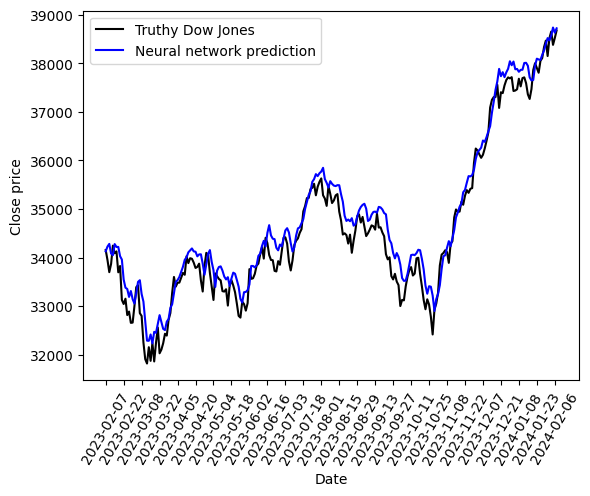

In [10]:
# Wizualizacja predykcji sieci na danych historycznych Dow Jonesa z nimi samymi
import matplotlib.pyplot as plt
plt.plot(data_test.index, y_test, c='k')
plt.plot(data_test.index, predictions, c='b')
plt.xticks(range(0, 252, 10), rotation=60)
plt.xlabel('Date')
plt.ylabel('Close price')
plt.legend(['Truthy Dow Jones', 'Neural network prediction'])
plt.show()

In [11]:
import matplotlib.pyplot as plt

def make_loss_plot(history):
  #import seaborn as sns
  #sns.set()
  loss = history.history['loss']
  epochs = range(1, len(loss) + 1)
  plt.figure(figsize=(9, 4))
  plt.plot(epochs, loss, label='Strata treningowa', marker='o')
  plt.legend()
  plt.title('Strata trenowania')
  plt.xlabel('Epoki')
  plt.ylabel('Strata')
  plt.show()

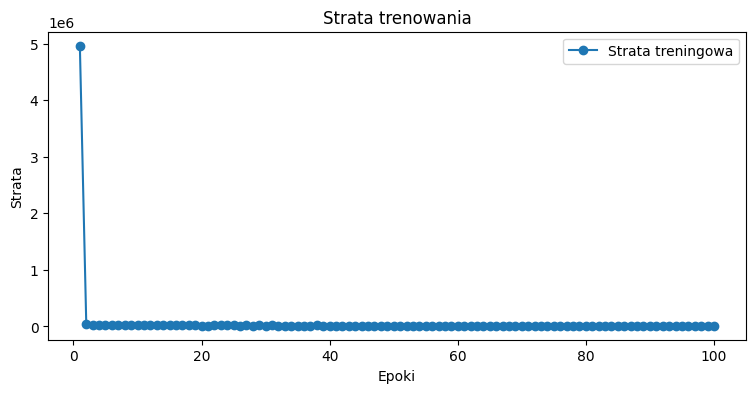

In [12]:
make_loss_plot(history)

In [13]:
# Porównanie z inną metodą - SVR: regresja wektorów nośnych z
# jądrem liniowym i radialną funkcją bazową
'''
param_grid = [
    {'kernel':['linear'], 'C': [100, 300, 500],
     'epsilon': [0.00003, 0.0001]},
    {'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                'C': [10, 100, 1000], 'epsilon': [0.00003, 0.0001]}
]
'''

"\nparam_grid = [\n    {'kernel':['linear'], 'C': [100, 300, 500],\n     'epsilon': [0.00003, 0.0001]},\n    {'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],\n                'C': [10, 100, 1000], 'epsilon': [0.00003, 0.0001]}\n]\n"

In [14]:
param_grid = [
    {'kernel':'linear',
     'C': 500,
     'epsilon': 0.0001}
    ]

In [15]:
# importuję funkcję regresyjnej maszyny wektorów nośnych
from sklearn.svm import SVR
#svr = SVR?

In [16]:
#from sklearn.model_selection import GridSearchCV
#grid_search = GridSearchCV(svr, param_grid, cv=5, scoring='r2')
#grid_search.fit(X_scaled_train, y_train)

In [17]:
#print(grid_search.best_params_)

In [18]:
#svr_best = grid_search.best_estimator_

In [19]:
svr = SVR(kernel='linear', epsilon=0.05, C=10)
# best param: C=500, epsilon=0.0001
# but time is tragic

# trening modelu svr
svr.fit(X_scaled_train, y_train)

SVR(C=10, epsilon=0.05, kernel='linear')

In [20]:
# Testy SVRa
#predictions_svr = svr_best.predict(X_scaled_test)
predictions_svr = svr.predict(X_scaled_test)

# Metryki
print(f'Błąd średniokwadratowy: {mean_squared_error(y_test, predictions_svr):.3f}')

Błąd średniokwadratowy: 67823.995


In [21]:
print(f'Błąd bezwględny: {mean_absolute_error(y_test, predictions_svr):.3f}')

Błąd bezwględny: 210.149


In [22]:
print(f'R^2: {r2_score(y_test, predictions_svr):.3f}')

R^2: 0.974


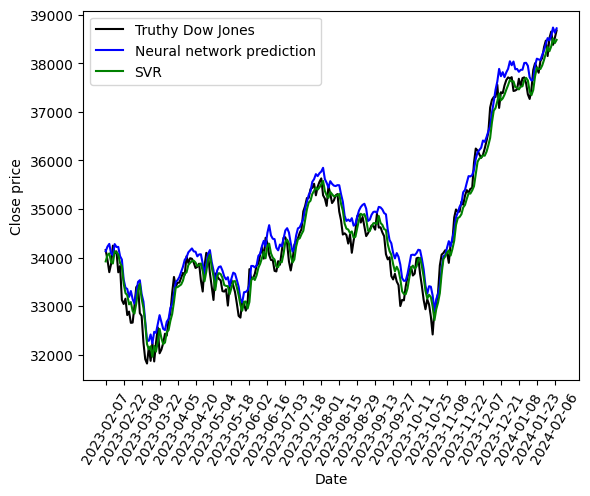

In [23]:
# wizualizacja porównania notowań oraz predykcji sieci neuronowej i SVR na danych testowych
plt.plot(data_test.index, y_test, c='k')
plt.plot(data_test.index, predictions, c='b')
plt.plot(data_test.index, predictions_svr, c='g')
plt.xticks(range(0, 252, 10), rotation=60)
plt.xlabel('Date')
plt.ylabel('Close price')
plt.legend(['Truthy Dow Jones', 'Neural network prediction', 'SVR'])
plt.show()